In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/goldstock v1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Select the 'Close' column for prediction

In [3]:
close_prices = df['Close'].values.reshape(-1, 1)

# Plot the original closing prices per year

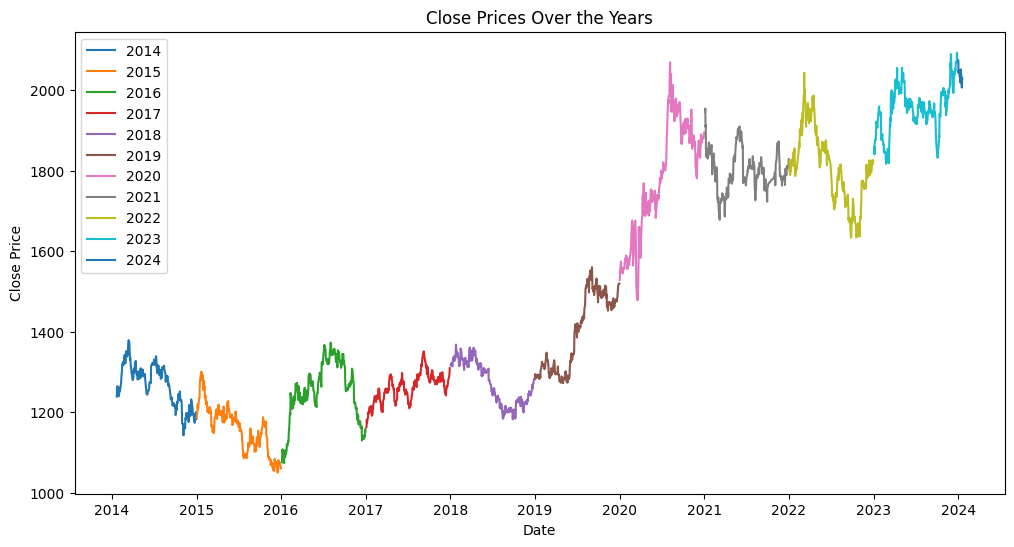

In [4]:
df['Year'] = df['Date'].dt.year
plt.figure(figsize=(12, 6))
for year, group in df.groupby('Year'):
    plt.plot(group['Date'], group['Close'], label=str(year))
plt.title('Close Prices Over the Years')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Scale the data to the range (0, 1)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

# Create sequences for LSTM

In [6]:
sequence_length = 60
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_close_prices, sequence_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into training and testing data

In [14]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model

In [8]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train the model

In [9]:
model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0282 - val_loss: 0.0023
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.1695e-04 - val_loss: 0.0015
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.7528e-04 - val_loss: 0.0017
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.6892e-04 - val_loss: 0.0013
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7186e-04 - val_loss: 0.0016
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.7522e-04 - val_loss: 0.0012
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.2048e-04 - val_loss: 0.0015
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.3391e-04 - val_loss: 0.0011
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.1595e-04 - val_loss: 0.0011
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.0328e-04 - val_loss: 0.0010
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.4373e-04 - val_loss: 0.0019
Epoch 12/30
62/62 ━━━━━━━━━━━━━━

# Generate predictions for the next 5 years

In [10]:
future_days = 5 * 365
last_sequence = scaled_close_prices[-sequence_length:]
future_predictions = []
for _ in range(future_days):
    next_input = last_sequence.reshape((1, sequence_length, 1))
    next_prediction = model.predict(next_input, verbose=0)
    future_predictions.append(next_prediction[0, 0])
    last_sequence = np.append(last_sequence[1:], next_prediction, axis=0)

# Inverse transform the predictions to original scale

In [11]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates

In [15]:
last_date = df['Date'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, future_days + 1)]
future_data = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_predictions.flatten()})
print(future_data.tail(50))


           Date  Predicted_Close
1775 2028-11-29      1905.126953
1776 2028-11-30      1905.126831
1777 2028-12-01      1905.126953
1778 2028-12-02      1905.126953
1779 2028-12-03      1905.126953
1780 2028-12-04      1905.126953
1781 2028-12-05      1905.126953
1782 2028-12-06      1905.126953
1783 2028-12-07      1905.126953
1784 2028-12-08      1905.126953
1785 2028-12-09      1905.126953
1786 2028-12-10      1905.126953
1787 2028-12-11      1905.126953
1788 2028-12-12      1905.126953
1789 2028-12-13      1905.126831
1790 2028-12-14      1905.126831
1791 2028-12-15      1905.126831
1792 2028-12-16      1905.126831
1793 2028-12-17      1905.126831
1794 2028-12-18      1905.126831
1795 2028-12-19      1905.126831
1796 2028-12-20      1905.126831
1797 2028-12-21      1905.126831
1798 2028-12-22      1905.126831
1799 2028-12-23      1905.126831
1800 2028-12-24      1905.126953
1801 2028-12-25      1905.126953
1802 2028-12-26      1905.126953
1803 2028-12-27      1905.126953
1804 2028-